In [72]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import re
from bs4 import BeautifulSoup
from dateutil import parser
from datetime import datetime

#Plotting Activity by Hour for Chrome and YouTube

In [73]:
# Load the JSON data
with open('History_1_Month.json', 'r', encoding='utf-8') as f:
    chrome_data = json.load(f)

# Extract the list of browsing records
records = chrome_data.get("Browser History", [])

# Convert records to a DataFrame
df_chrome = pd.DataFrame(records)

# Convert microseconds to datetime
df_chrome['timestamp'] = df_chrome['time_usec'].apply(
    lambda x: datetime.utcfromtimestamp(x / 1e6)
)

# Convert UTC to EST
import pytz
eastern = pytz.timezone('US/Eastern')
df_chrome['timestamp_local'] = df_chrome['timestamp'].dt.tz_localize('UTC').dt.tz_convert(eastern)

# Create separate date and hour columns for easier grouping
df_chrome['date'] = df_chrome['timestamp'].dt.date
df_chrome['hour'] = df_chrome['timestamp'].dt.hour


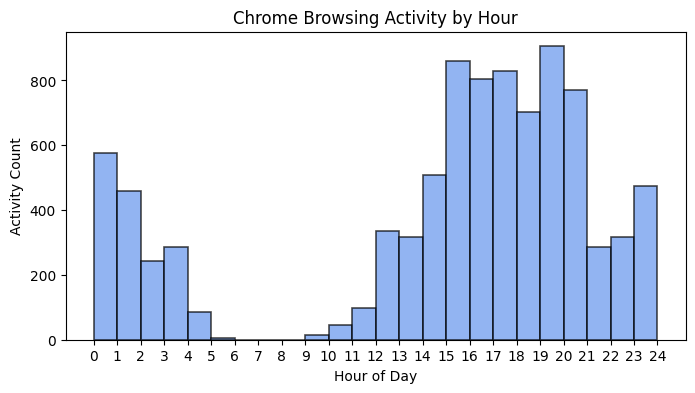

In [74]:
with open('History_1_Month.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

chrome_df = pd.DataFrame(data["Browser History"])

chrome_df['datetime'] = pd.to_datetime(chrome_df['time_usec'], unit='us', utc=True).dt.tz_convert('US/Eastern')


chrome_df['hour'] = chrome_df['datetime'].dt.hour

# Quick visualization: Activity by hour (Chrome)
plt.figure(figsize=(8,4))
plt.hist(
    chrome_df['hour'],
    bins=24,
    range=(0,24),
    alpha=0.7,
    color='cornflowerblue',
    edgecolor='black',      # Draw lines between bars
    linewidth=1.2           # Thickness of the lines
)
plt.xlabel('Hour of Day')
plt.ylabel('Activity Count')
plt.title('Chrome Browsing Activity by Hour')

# Ensure x-axis ticks from 0 to 24
plt.xticks(range(0, 25))

plt.show()


/usr/local/lib/python3.11/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


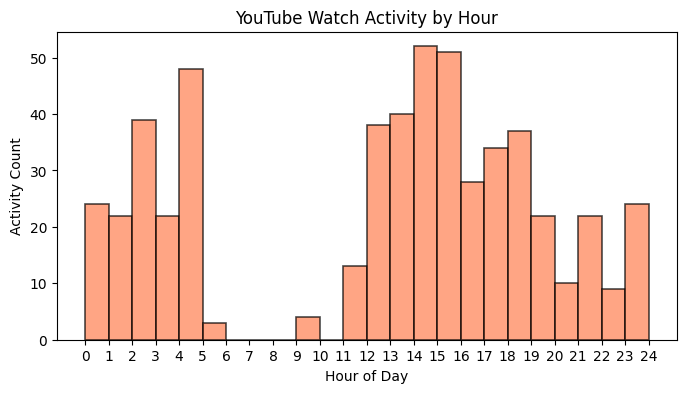

In [131]:
with open('watch-history.html', 'r', encoding='utf-8') as f:
    soup = BeautifulSoup(f, 'html.parser')

yt_entries = []

for div in soup.find_all('div', class_='content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1'):
    text = div.get_text(separator=" ", strip=True)

    # 1) Replace narrow no-break spaces with normal spaces
    text = text.replace('\u202f', ' ')

    # 2) Try to locate something like "Feb 19, 2025, 3:09:19 AM EST" inside the text.
    #    We'll do a regex to capture the entire date-time chunk plus the timezone.
    match = re.search(r'([A-Za-z]{3,9} \d{1,2}, \d{4}, .*?(AM|PM) \w+)', text)
    # This tries to match: "Feb 19, 2025, <...> AM EST" or "October 11, 2024, <...> PM PST", etc.

    if match:
        raw_str = match.group(1)
        try:
            # 3) Let dateutil handle the parse (including recognized timezones).
            #    If Python doesn't know "EST" as a named tz, dateutil can still parse it.
            dt = parser.parse(raw_str)
            yt_entries.append(dt)
        except Exception as e:
            # If dateutil fails, you could remove the trailing timezone and parse manually.
            pass

# Create a DataFrame
youtube_df = pd.DataFrame(yt_entries, columns=['datetime'])

# Filter to only data after or on Jan 20, 2025 (1 Month)
cutoff = pd.to_datetime("2025-01-20")
youtube_df = youtube_df[youtube_df['datetime'] >= cutoff]

# Create 'hour' column for plotting
youtube_df['hour'] = youtube_df['datetime'].dt.hour

# Plot
plt.figure(figsize=(8,4))
plt.hist(
    youtube_df['hour'],
    bins=24,
    range=(0,24),
    alpha=0.7,
    color='coral',
    edgecolor='black',
    linewidth=1.2
)
plt.xlabel('Hour of Day')
plt.ylabel('Activity Count')
plt.title('YouTube Watch Activity by Hour')

# Ensure x-axis ticks from 0 to 24
plt.xticks(range(0, 25))

plt.show()



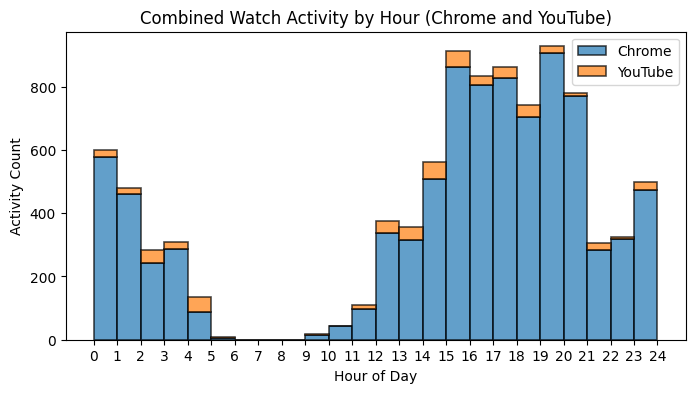

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Combine into one
combined_df = pd.concat([chrome_df, youtube_df], ignore_index=True)

hourly_counts = (
    combined_df
    .groupby(['hour'])
    .size()
    .reset_index(name='counts')
)

import pandas as pd
import matplotlib.pyplot as plt

# Separate the data
chrome_hours = chrome_df['hour']
youtube_hours = youtube_df['hour']

# Plot
plt.figure(figsize=(8,4))
plt.hist(
    [chrome_hours, youtube_hours],
    bins=24,
    range=(0,24),
    alpha=0.7,
    label=['Chrome', 'YouTube'],
    edgecolor='black',
    linewidth=1.2,
    stacked=True
)
plt.xlabel('Hour of Day')
plt.ylabel('Activity Count')
plt.title('Combined Watch Activity by Hour (Chrome and YouTube)')

plt.xticks(range(0, 25))
plt.legend()
plt.show()


# Estimating Wake-Up Time and Bed Time

In [144]:
import pandas as pd

# Combine Chrome and YouTube into one DataFrame
combined_df = pd.concat([chrome_df, youtube_df], ignore_index=True)

# Group by hour
hourly_counts = (
    combined_df
    .groupby('hour')
    .size()
    .reset_index(name='counts')
    .sort_values('hour')
)

# Compute how usage changes from one hour to the next
# We'll create a diff column that measures the difference from the previous row in chronological order
hourly_counts['diff'] = hourly_counts['counts'].diff()

hourly_counts.reset_index(drop=True, inplace=True)
hourly_counts


,hour,counts,diff
0,0,600,NaN
1,1,481,-119.0
2,2,283,-198.0
3,3,308,25.0
4,4,135,-173.0
5,5,8,-127.0
6,9,18,10.0
7,10,44,26.0
8,11,110,66.0
9,12,374,264.0


In [145]:
# Top 3 increases = largest positive diffs
top_3_increases = hourly_counts.sort_values('diff', ascending=False).head(3)

# Top 3 drops = largest negative diffs (lowest diffs)
top_3_drops = hourly_counts.sort_values('diff', ascending=True).head(3)

print("Top 3 Biggest Increases:")
print(top_3_increases[['hour', 'counts', 'diff']])

print("\nTop 3 Biggest Drops:")
print(top_3_drops[['hour', 'counts', 'diff']])


Top 3 Biggest Increases:
    hour  counts   diff
12    15     912  351.0
9     12     374  264.0
11    14     561  205.0

Top 3 Biggest Drops:
    hour  counts   diff
18    21     307 -473.0
2      2     283 -198.0
4      4     135 -173.0


In [146]:
def hour_to_ampm(h):
    """
    Convert an integer hour (0-23) into a string like "12 AM", "1 AM", ..., "12 PM", "1 PM", etc.
    """
    h = int(h)
    if h == 0:
        return "12 AM"   # midnight hour
    elif 1 <= h < 12:
        return f"{h} AM"
    elif h == 12:
        return "12 PM"  # noon hour
    else:
        # h is between 13 and 23
        return f"{h - 12} PM"

def describe_transition(row, hourly_df):
    """
    Given a row from hourly_counts (with 'hour', 'counts', 'diff'),
    produce a string describing how usage changed from the previous hour,
    labeling the hours in 12-hour AM/PM format.
    """
    hour = row['hour']
    diff_val = row['diff']
    current_counts = row['counts']

    if hour == 0:
        return f"At {hour_to_ampm(hour)}, no previous hour data. (diff={diff_val})"

    # Find the row for hour = hour - 1
    prev_row = hourly_df[hourly_df['hour'] == hour - 1]
    if prev_row.empty:
        return (f"No data for {hour_to_ampm(hour - 1)} to {hour_to_ampm(hour)} "
                f"(diff={diff_val}).")

    prev_counts = prev_row.iloc[0]['counts']
    direction = "increased" if diff_val > 0 else "decreased"
    abs_diff = abs(diff_val)

    return (f"From {hour_to_ampm(hour - 1)} to {hour_to_ampm(hour)}, "
            f"usage {direction} by {abs_diff:.0f} "
            f"(from {prev_counts} to {current_counts}).")


In [147]:
top_3_increases = hourly_counts.sort_values('diff', ascending=False).head(3)
top_3_drops = hourly_counts.sort_values('diff', ascending=True).head(3)

print("Top 3 Biggest Increases:")
for _, row in top_3_increases.iterrows():
    print(describe_transition(row, hourly_counts))

print("\nTop 3 Biggest Drops:")
for _, row in top_3_drops.iterrows():
    print(describe_transition(row, hourly_counts))


Top 3 Biggest Increases:
From 2 PM to 3 PM, usage increased by 351 (from 561.0 to 912.0).
From 11 AM to 12 PM, usage increased by 264 (from 110.0 to 374.0).
From 1 PM to 2 PM, usage increased by 205 (from 356.0 to 561.0).

Top 3 Biggest Drops:
From 8 PM to 9 PM, usage decreased by 473 (from 780.0 to 307.0).
From 1 AM to 2 AM, usage decreased by 198 (from 481.0 to 283.0).
From 3 AM to 4 AM, usage decreased by 173 (from 308.0 to 135.0).


# Estimating Sleeping Window

In [148]:
# Count how many events occur in each hour of the day
hourly_counts = (
    combined_df
    .groupby('hour')
    .size()
    .reset_index(name='counts')
)

# Make sure it’s sorted by hour so it goes 0..23
hourly_counts.sort_values('hour', inplace=True)
hourly_counts.reset_index(drop=True, inplace=True)

# Convert to a simple array where index=hour, value=counts
counts_array = np.zeros(24, dtype=int)  # default 0 for hours with no events
for _, row in hourly_counts.iterrows():
    hour = row['hour']
    cnt = row['counts']
    counts_array[hour] = cnt

In [149]:
# Extend the array by repeating its first 7 elements (for the 8-hr window to wrap)
extended = np.concatenate([counts_array, counts_array[:7]])

best_start = None
best_sum = float('inf')

# Slide over each possible start hour (0..23)
for start_hour in range(24):
    # sum of the 8 hours from start_hour to start_hour+7
    window_sum = extended[start_hour : start_hour + 8].sum()
    if window_sum < best_sum:
        best_sum = window_sum
        best_start = start_hour

print("Smallest total activity:", best_sum)
print("8-hour window start:", best_start, "-> end:", (best_start + 8) % 24)


Smallest total activity: 315
8-hour window start: 4 -> end: 12


In [150]:
combined_df = pd.concat([chrome_df, youtube_df], ignore_index=True)

combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], errors='coerce')

# Add a weekday column: Monday=0, Tuesday=1, ... Sunday=6
combined_df['weekday'] = combined_df['datetime'].dt.dayofweek

combined_df['hour'] = combined_df['datetime'].dt.hour

# --- Define a helper function to find the minimal 8-hour window for a given weekday ---
def find_minimal_window_for_weekday(wd, df, window=8):
    """
    For a given weekday (wd: 0=Monday,...,6=Sunday) and DataFrame df,
    aggregates the event counts by hour (0-23) and returns the start hour,
    end hour, and total activity in the contiguous window of length `window`
    (with wrap-around) that has the minimum total activity.
    """
    # Filter events for this weekday
    df_wd = df[df['weekday'] == wd].copy()

    # Group by hour and count events; ensure we cover hours 0-23 (fill missing with 0)
    counts_series = df_wd.groupby('hour').size().reindex(range(24), fill_value=0)
    counts_array = counts_series.values  # an array of length 24

    # Extend the array for wrap-around
    extended = np.concatenate([counts_array, counts_array[:window-1]])

    best_start = None
    best_sum = float('inf')

    # Slide an 8-hour window over the extended array, starting at each hour 0 to 23
    for start in range(24):
        window_sum = extended[start:start+window].sum()
        if window_sum < best_sum:
            best_sum = window_sum
            best_start = start

    best_end = (best_start + window) % 24
    return best_start, best_end, best_sum, counts_array

# Loop over each weekday (0=Monday,...,6=Sunday) and find the minimal 8-hour window
results = []
weekday_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
                 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

for wd in range(7):
    start, end, total_activity, counts_array = find_minimal_window_for_weekday(wd, combined_df, window=8)
    results.append({
         'weekday': wd,
         'weekday_name': weekday_names[wd],
         'start_hour': start,
         'end_hour': end,
         'total_activity': total_activity,
         'start_str': hour_to_ampm(start),
         'end_str': hour_to_ampm(end)
    })

results_df = pd.DataFrame(results)
print("Minimal activity 8-hour windows by weekday:")
print(results_df[['weekday_name', 'start_str', 'end_str', 'total_activity']])

Minimal activity 8-hour windows by weekday:
  weekday_name start_str end_str  total_activity
0       Monday      4 AM   12 PM               7
1      Tuesday      3 AM   11 AM              95
2    Wednesday      4 AM   12 PM              37
3     Thursday      4 AM   12 PM              13
4       Friday      4 AM   12 PM              21
5     Saturday      3 AM   11 AM              25
6       Sunday      5 AM    1 PM               6


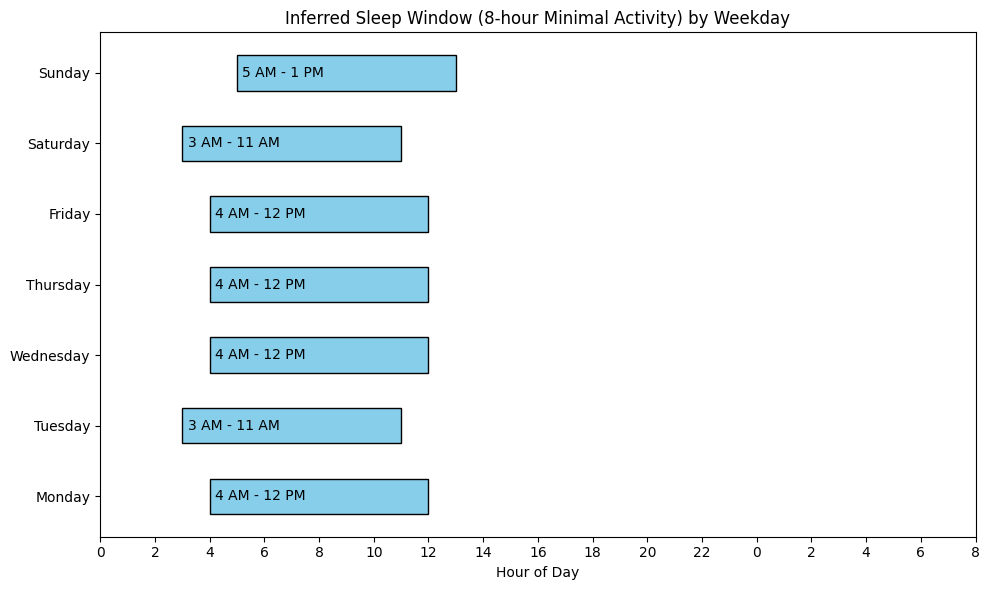

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Results from running minimal 8-hour window function for each weekday
results = [
    {'weekday': 0, 'weekday_name': 'Monday',    'start_hour': 4, 'end_hour': 12,  'total_activity': 7},
    {'weekday': 1, 'weekday_name': 'Tuesday',   'start_hour': 3, 'end_hour': 11,  'total_activity': 95},
    {'weekday': 2, 'weekday_name': 'Wednesday', 'start_hour': 4, 'end_hour': 12,  'total_activity': 37},
    {'weekday': 3, 'weekday_name': 'Thursday',  'start_hour': 4,  'end_hour': 12,  'total_activity': 13},
    {'weekday': 4, 'weekday_name': 'Friday',    'start_hour': 4,  'end_hour': 12,  'total_activity': 21},
    {'weekday': 5, 'weekday_name': 'Saturday',  'start_hour': 3,  'end_hour': 11,  'total_activity': 25},
    {'weekday': 6, 'weekday_name': 'Sunday',    'start_hour': 5, 'end_hour': 13,  'total_activity': 6},
]
results_df = pd.DataFrame(results)
results_df['start_str'] = results_df['start_hour'].apply(hour_to_ampm)
results_df['end_str'] = results_df['end_hour'].apply(hour_to_ampm)

# For windows that cross midnight, we want a continuous representation.
def convert_window(start, end):
    """Returns (plot_start, plot_end) where plot_end is adjusted if needed."""
    if start > end:
        return start, end + 24
    else:
        return start, end

# Apply conversion to get continuous values.
results_df['plot_start'], results_df['plot_end'] = zip(*results_df.apply(
    lambda row: convert_window(row['start_hour'], row['end_hour']), axis=1))
# Our window is fixed at 8 hours.
results_df['duration'] = 8

# Sort by weekday
results_df = results_df.sort_values('weekday')

# --- Plotting a horizontal bar graph ---
plt.figure(figsize=(10,6))

# Use plt.barh; y-position will be the weekday index (0 for Monday, etc.)
y_positions = np.arange(len(results_df))
plt.barh(y_positions, results_df['duration'], left=results_df['plot_start'],
         height=0.5, color='skyblue', edgecolor='black')

# Label each bar with the weekday name.
plt.yticks(y_positions, results_df['weekday_name'])

# For the x-axis, we want to show hours on a 24-hour clock.
# Our x-axis may run beyond 24 if a bar wraps around
x_ticks = np.arange(0, 33, 2)
x_tick_labels = [str(t % 24) for t in x_ticks]
plt.xticks(x_ticks, x_tick_labels)

plt.xlabel('Hour of Day')
plt.title('Inferred Sleep Window (8-hour Minimal Activity) by Weekday')

# Annotate each bar with the start and end times in AM/PM format.
for i, row in results_df.iterrows():
    plt.text(row['plot_start'] + 0.2, i, f"{row['start_str']} - {row['end_str']}",
             va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()
